# flonb

[![Build Status](https://github.com/hazbottles/flonb/workflows/build/badge.svg)](https://github.com/hazbottles/flonb/actions?query=workflow%3Abuild)

`flonb` lets you develop data pipelines (a.k.a task graphs) with very rapid "modify -> run -> inpect" iteration loops.

It lets you:
- __Label__ each run of the pipetline with a human-readable list of options. Easy to see what you did to the data, easy to reproduce. Avoid the hell of _I-changed-a-whole-bunch-of-options-and-lost-track_ that I, at least, often get myself into.
- __Cache__ results automagically based on the labels. Change an option, add a new option - `flonb` will manage the cache without you having to implement code to update the unique result identifier!
- __Parallel__ execution of your pipeline. `flonb` pipelines are interoperable with [dask](https://docs.dask.org/en/latest/) schedulers.

So you can spend more time focussing on your logic, and less time on error-prone boilerplate code.

# Installation

`$ pip install flonb`

Note this also installs `dask.core`. If you require dask extensions (e.g. _dask.bag_, _dask.dataframe_, _dask.delayed_, etc...) then make sure to install them yourself. It can be a bit unclear with `dask` what extensions you have installed! https://docs.dask.org/en/latest/install.html

# Example basic usage

Here is a simple pipeline that counts the number of times a word appears in a block of text.

Define a Task Graph using:

- `flonb.task_func` decorator for each processing step.
- `flonb.Dep` as the default parameter value to tell `flonb` which tasks to use as inputs.

In [1]:
import flonb


@flonb.task_func
def parse_text(normalise):
    text = (
        "Badger badger badger Mushroom mushroom "
        "Badger badger badger Mushroom mushroom "
        "Badger badger badger SNAKE its a SNAKE "
    )
    words = text.split(" ")
    if normalise:
        words = [w.lower() for w in words]
    return words


@flonb.task_func
def word_count(word, text=flonb.Dep(parse_text)):
    return sum([w == word for w in text])

You can still run your pipeline by manually calling the functions the usual way. This can be handy for debugging:

In [2]:
text = parse_text(normalise=False)
word_count(word="badger", text=text)

6

Or you can use the `.compute` method that `@flonb.task_func` adds to your function.

Note that we supply all the options that specify the entire Task Graph. Even though the function `word_count` does not explicitly require the option `normalise`, its dependency `parse_text` does.

In [3]:
word_count.compute(normalise=False, word="badger")

6

Change the options, and everything works like you'd expect.

In [4]:
word_count.compute(normalise=True, word="badger")

9

Importantly, you can use a single option in multiple places in the same pipeline:

In [5]:
@flonb.task_func
def summary_str(word, normalise, count=flonb.Dep(word_count)):
    return f"word={word}, normalise={normalise} -> count={count}"

print(summary_str.compute(word="mushroom", normalise=True))

word=mushroom, normalise=True -> count=4


A typical workflow using `flonb` is:

1. Run pipeline with different options to see the impacts on your data.
1. Add new options and/or steps.
1. Repeat.

`flonb` is especially useful because you can add new options early in the Task Graph without having to manually propagate the option through every function in the pipeline!

# Task Graphs

We can visualize the graph using `dask[complete]` + `graphviz`. You can install these with conda:

`$ conda install dask python-graphviz`

See https://docs.dask.org/en/latest/graphviz.html for other installation options.

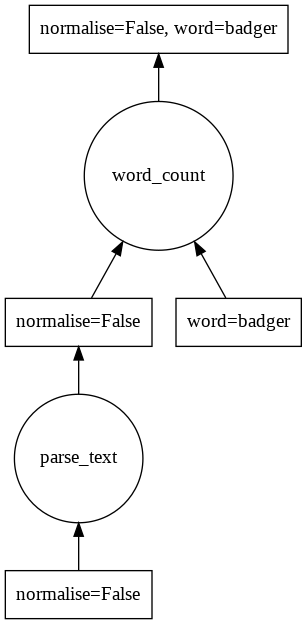

In [6]:
import dask
graph, key = word_count.graph_and_key(normalise=False, word="badger")
dask.visualize(graph)

# list dependencies

Oftentimes you will want to combine multiple computations with different versions of an __option__.

You can do this by supplying a `list` to `flonb.Dep` and using the `.partial(**options)` method.

In [7]:
@flonb.task_func
def count_many_words(
    counts=flonb.Dep(
        [word_count.partial(word="badger"), word_count.partial(word="mushroom")]
    )
):
    return counts  # so we can see how flonb substitutes the counts flonb.Dep parameter

count_many_words.compute(normalise=False)

[6, 2]

Lists can be nested, and non-`flonb.Task` objects are ignored:

In [8]:
@flonb.task_func
def count_many_words_heterogenous_nested_list(
    counts=flonb.Dep(
        [
            [word, word_count.partial(word=word)]
            for word in ["badger", "mushroom", "snake", "cow"]
        ]
    )
):
    return counts  # so we can see how flonb substitutes the counts flonb.Dep parameter

count_many_words_heterogenous_nested_list.compute(normalise=True)

[['badger', 9], ['mushroom', 4], ['snake', 2], ['cow', 0]]

# Caching

`flonb` uses the options supplied to a task to uniquely identify it, and can automagically cache on disk the results using this identifier.

If a task has been cached, `flonb` will fetch the cached result instead of computing not only the task _but also any of its dependencies_.

__Warning__: If you invalidate your cache by changing what an option means (e.g. fixing a bug in your code), make sure to delete your cache!

In [9]:
flonb.set_cache_dir("/tmp")

@flonb.task_func(cache_disk=True)
def power(x, y):
    print(f"computing {x}**{y}")  # side effect - doesn't happen when cached result called
    return x**y


# only prints once
power.compute(x=3, y=3)
power.compute(x=3, y=3)

computing 3**3


27

In [10]:
# each unique set of options labels the cache
power.compute(x=3, y=2)
power.compute(x=2, y=3)

computing 3**2
computing 2**3


8

# Dynamic dependencies

Sometimes you want to know the value of an option before you resolve the dependencies. `flonb.DynamicDep` has your back here.



In [11]:
@flonb.task_func
def add(x, y):
    return x + y

@flonb.task_func
def multiply(a, b):
    return a * b

@flonb.task_func
def multiply_or_add(    
    result=flonb.DynamicDep(lambda mode: {"add": add, "multiply": multiply}[mode])
):
    return result

Here the option `'mode'` determines what the task graph looks like, and even what options are available:

In [12]:
multiply_or_add.compute(mode="multiply", a=4, b=3)

12

In [13]:
multiply_or_add.compute(mode="add", x=4, y=3)

7

# Multiproccesing

`flonb` implements the `dask` Task Graph specification.

1. call `.graph_and_key()` on your task.
1. feed into `dask` as required.

In [14]:
import dask.multiprocessing
import time

@flonb.task_func
def add_one_in_one_second(x):
    time.sleep(1)  # artifically slow down the task
    result = x + 1
    return result

@flonb.task_func
def do_sums(data=flonb.Dep([add_one_in_one_second.partial(x=x) for x in range(10)])):
    return data


graph, key = do_sums.graph_and_key()

# single process
tic = time.time()
dask.get(graph, key)
print(f"Single-process execution took {time.time() - tic:.2f} seconds.")

print("------------")

# multiple process
tic = time.time()
dask.multiprocessing.get(graph, key, num_workers=4)
print(f"Multiproccessing execution took {time.time() - tic:.2f} seconds.")

Single-process execution took 10.01 seconds.
------------
Multiproccessing execution took 3.30 seconds.


# Alternatives

There are many high quality frameworks that let you build and run task graphs. `flonb` is lightweight and easy to experiment with, but make sure to check out others if you want to delve further into your options. Here are some suggestions:

- `dask`
- `luigi`
- `airflow`

# Acknowledgements

A big thanks to Solcast (https://solcast.com) for supporting the development of `flonb`.